Name: Ying Wang

Github Username: Notrew

USC ID: 9965632493

In [2]:
import os 
import shutil
import math

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,Flatten,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import EfficientNetB0,VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_v
from tensorflow.keras.optimizers import Adam
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## a. In this problem, we are trying to build a classifier that distinguishes images of 20 bird species. You are provided with text data in twenty folders.

## b. Data Exploration and Pre-processing

### b.i. Images in each class are given in separate folders. The file Classes.xlsx provides the classes assigned to the bird species images in each folder. 
### b.i. Therefore, you encode your classes using one-hot encoding and Classes.xlsx.
### b.ii. Randomly select $\lceil{0.7ni}\rceil$ images from each folder as your training set,  $\lceil{0.15ni}\rceil$ as validation set, and the rest as your test set, where ni is the number of images in folder i and  $\lceil{x}\rceil$ is the ceiling of x.
### b.iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dirnames = []
filenames = []
dirpaths= []
for dirpath,dirname,filename in os.walk("/content/drive/MyDrive/presonal_colab/552-project/Data/images"):
  dirpaths.append(dirpath)
  if len(dirname)!= 0:
    dirnames = dirname
  if len(filename)!=0:
    filenames.append(filename)
  # print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")
dirpaths.pop(0)

'/content/drive/MyDrive/presonal_colab/552-project/Data/images'

In [ ]:
# split data into train, validation and test set
train_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/train_set"
vali_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/vali_set"
test_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/test_set"
os.mkdir(train_path)
os.mkdir(vali_path)
os.mkdir(test_path)
for i in range(0,20):
  img_names = os.listdir(dirpaths[i])
  train_size = math.ceil(0.7*len(filenames[i]))
  vali_size = math.ceil(0.15*len(filenames[i]))
  test_size = len(filenames[i])-train_size-vali_size

  train_imgs = filenames[i][0:train_size]
  vali_imgs = filenames[i][train_size:train_size+vali_size]
  test_imgs = filenames[i][-test_size:]

  os.mkdir(train_path+"/"+dirnames[i])
  os.mkdir(vali_path+"/"+dirnames[i])
  os.mkdir(test_path+"/"+dirnames[i])

  for img in train_imgs:
    old_path = os.path.join(dirpaths[i],img)
    new_path = os.path.join(train_path,dirnames[i],img)
    shutil.copy(old_path,new_path)
  for img in vali_imgs:
    old_path = os.path.join(dirpaths[i],img)
    new_path = os.path.join(vali_path,dirnames[i],img)
    shutil.copy(old_path, new_path)
  for img in test_imgs:
    old_path = os.path.join(dirpaths[i],img)
    new_path = os.path.join(test_path,dirnames[i],img)
    shutil.copy(old_path, new_path)

In [6]:
# load data
# and class_mode='categorical' automatically performs one hot encoding of the classes
train_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/train_set"
vali_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/vali_set"
test_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/test_set"

ori_gen_efnb0 = ImageDataGenerator()
ori_gen_vgg = ImageDataGenerator(preprocessing_function = preprocess_input_v)

train_data_efnb0 = ori_gen_efnb0.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)
train_data_vgg = ori_gen_vgg.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)
vali_data = ori_gen_efnb0.flow_from_directory(
    vali_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=False)
test_data = ori_gen_efnb0.flow_from_directory(
    test_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=False)
# len(train_data) = num/batch(+1)
# train_data[i-1][0] the i-th batch
# train_data[i-1][0][j-1] the j-th image

Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


## c. Transfer Learning

### c.i. 
When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only around 50-60 images per class. 

Given that we have 20 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will **use pre-trained models EfficientNetB0 and VGG16**. For both pre-trained networks, you will **only train the last fully connected layer**, and will **freeze all layers before them** (i.e. we do not change their parameters during training) and **use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image**.

### c.ii. 
To **perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images** in your training set for image augmentation. You can use various tools to do this, including **OpenCV**.

In [7]:
# reference https://datamonje.com/image-data-augmentation/#crop and
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/train_set"
vali_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/vali_set"
test_path = "/content/drive/MyDrive/presonal_colab/552-project/Data/test_set"
# set up crop
def random_crop(np_tensor):
  new_height = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[0])
  new_width = int(np.random.uniform(0.7, 1.30) * np_tensor.shape[1])
  cropped = tf.image.resize_with_crop_or_pad(np_tensor, new_height, new_width)
  augmnted_tensor = tf.image.resize(cropped, np_tensor.shape[:2])
  return np.array(augmnted_tensor)
crop_gen = ImageDataGenerator(preprocessing_function=random_crop)
train_crop = crop_gen.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

# set up randomly zoom
# zooms an image to between 80% to 125%
zoom_gen = ImageDataGenerator(zoom_range=[0.8, 1.25])
train_zoom = zoom_gen.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

# set up rotate
rotate_gen = ImageDataGenerator(rotation_range=45)
train_rotate = rotate_gen.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

# set up vertical flip
flip_gen = ImageDataGenerator(vertical_flip=True)
train_v_flip = flip_gen.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

# set up contrast
def random_contrast(np_tensor):
  augmnted_tensor = tf.image.random_contrast(np_tensor, 0.5, 2)
  return np.array(augmnted_tensor)

contrast_gen = ImageDataGenerator(preprocessing_function=random_contrast)
train_contrast = contrast_gen.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

# set up translate
translate_gen = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25)
train_translate = translate_gen.flow_from_directory(
    train_path+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.
Found 827 images belonging to 20 classes.


In [8]:
train_dirpaths = []
train_dirnames = []
train_filenames = []
for dirpath,dirname,filename in os.walk("/content/drive/MyDrive/presonal_colab/552-project/Data/train_set"):
    train_dirpaths.append(dirpath)
    if len(dirname)!= 0:
        train_dirnames = dirname
    if len(filename)!=0:
        train_filenames.append(filename)
train_dirpaths.pop(0)

'/content/drive/MyDrive/presonal_colab/552-project/Data/train_set'

In [9]:
filepaths=[]
labels=[]
for i in range(0,20):
    klass = train_dirnames[i]
    # os.mkdir(os.path.join(aug_dir,klass)) # make the class subdirectories in the aug_dir
    for f in train_filenames[i]:        
        fpath=os.path.join(train_path,klass, f) 
        filepaths.append(fpath)
        labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1) # create the dataframe
groups=df.groupby('labels') # group by class

In [10]:
train_path_new = "/content/drive/MyDrive/presonal_colab/552-project/Data/train_set_with_aug"
def save_aug_img(aug_gen,groups):
  for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  
    sample_count=len(group)
    aug_img_count=0
    # target_dir=os.path.join("/content/drive/MyDrive/presonal_colab/552-project/Data/train_set/aug_images",label) 
    target_dir=os.path.join(train_path_new,label) 
    # os.mkdir(target_dir)
    flip_gen = ImageDataGenerator(vertical_flip=True)
    aug_imgs=aug_gen.flow_from_dataframe(group,x_col='filepaths',y_col="labels",target_size=(224,224),class_mode=None,
                                            batch_size=1, shuffle=False, save_to_dir=target_dir,save_prefix='aug_',save_format='jpg')
    while aug_img_count<len(group):
        images=next(aug_imgs)            
        aug_img_count += len(images)

In [ ]:
# save images after empirical regularization to original training directore
save_aug_img(crop_gen,groups)
save_aug_img(zoom_gen,groups)
save_aug_img(rotate_gen,groups)
save_aug_img(flip_gen,groups)
save_aug_img(contrast_gen,groups)
save_aug_img(translate_gen,groups)

Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 31 validated image filenames.
Found 42 validated image filenames.
Found 41 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 41 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 42 validated image filenames.
Found 31 validated image filenames.
Found 42 validated image filenames.
Found 41 validated image filenames.
Found 42 validated image fil

In [11]:
# reload training set
train_data_merge_efnb0 = ori_gen_efnb0.flow_from_directory(
    train_path_new+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)
train_data_merge_vgg = ori_gen_vgg.flow_from_directory(
    train_path_new+"/",
    class_mode = 'categorical',
    target_size=(224,224),
    batch_size=5,
    shuffle=True)

Found 5789 images belonging to 20 classes.
Found 5789 images belonging to 20 classes.


### c.iii. 
Use **ReLU** activation functions in the last layer and a **softmax layer**, along with **batch normalization** and a **dropout rate of 20%** as well as **ADAM optimizer**. Use **multinomial cross entropy loss**. You can try any batch size, but a **batch size of 5 seems reasonable**.


In [13]:
# build EfficientNetB0
efnb0_base = EfficientNetB0(include_top=False,weights='imagenet', input_shape=(224, 224, 3))
for layer in efnb0_base.layers[:-2]:
    layer.trainable = False
model_efnb0 = Sequential()
model_efnb0.add(efnb0_base)
model_efnb0.add(Flatten(name="flatten"))
model_efnb0.add(Dense(2048, activation='relu'))
model_efnb0.add(Dropout(0.2))
model_efnb0.add(Dense(20, activation='softmax'))
model_efnb0.build((None,224,224,3))
model_efnb0.summary()
model_efnb0.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              128452608 
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 20)                40980     
                                                                 
Total params: 132,543,159
Trainable params: 128,496,148
Non-trainable params: 4,047,011
_________________________________________________________________


In [17]:
# build vgg16
vgg_base = VGG16(include_top=False,weights='imagenet', input_shape=(224, 224, 3))
for layer in vgg_base.layers[:-2]:
    layer.trainable = False
model_vgg = Sequential()
model_vgg.add(vgg_base)
# model_vgg.add(Flatten(name="flatten"))
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(BatchNormalization())
model_vgg.add(Dense(2048, activation='relu'))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(20, activation='softmax'))
model_vgg.build((None,224,224,3))
model_vgg.summary()
optimizer = Adam(learning_rate=0.1)
model_vgg.compile(optimizer="adam", loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 2048)              1050624   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 20)               

### c.iv. 
Train the networks (EfficientNetB0 and VGG16) for **at least 50 epochs (preferably 100 epochs)** and perform **early stopping using the validation set**. Keep the network parameters that have the **lowest validation error**. 

**Plot the training and validation errors vs. epochs**

In [52]:
# train_data after mergering together is too large to fit(one epoch need about one hour if batch_size=5)
# too time consuming
# so I decide to let batch_size=50 and only run 20 epoches
n_steps = train_data_merge_efnb0.samples // 50
n_val_steps = vali_data.samples // 50

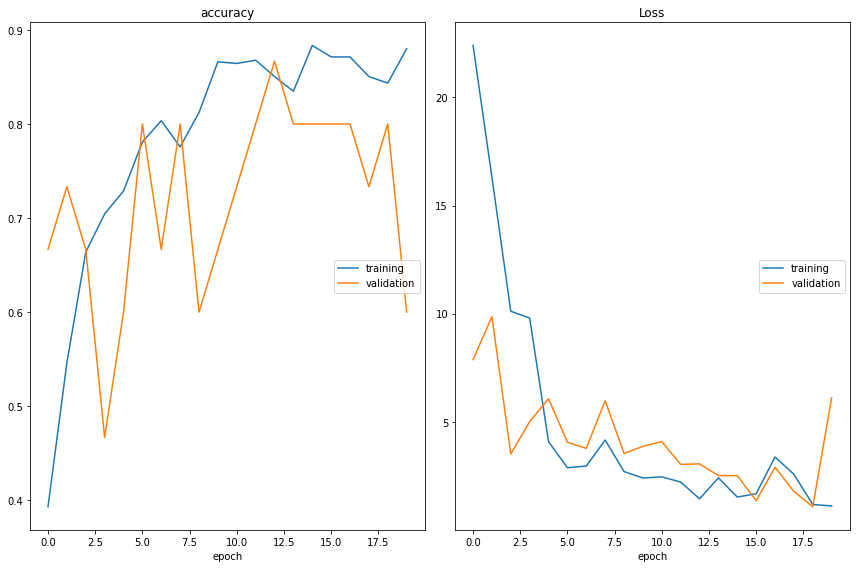

accuracy
	training         	 (min:    0.393, max:    0.883, cur:    0.880)
	validation       	 (min:    0.467, max:    0.867, cur:    0.600)
Loss
	training         	 (min:    1.111, max:   22.398, cur:    1.111)
	validation       	 (min:    1.075, max:    9.865, cur:    6.117)
115/115 [==============================] - 295s 3s/step - loss: 1.1107 - accuracy: 0.8800 - val_loss: 6.1166 - val_accuracy: 0.6000


In [57]:
plot_loss = PlotLossesCallback()
checkpoint_efnb0 = ModelCheckpoint(filepath='efnb0.weights.best.hdf5',
                                  save_best_only=True,verbose=1)
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10,
                           restore_best_weights=True,mode='min')
# fit EfficientNetB0
efnb0_history = model_efnb0.fit(train_data_merge_efnb0,
                            batch_size=50,
                            epochs=20,
                            validation_data=vali_data,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint_efnb0, early_stop, plot_loss],
                            # callbacks=[early_stop, plot_loss],
                            verbose=1)

In [58]:
# refit with best weights
model_efnb0.load_weights('efnb0.weights.best.hdf5') # initialize the best trained weights

efnb0_pred = model_efnb0.predict(test_data)
efnb0_pred_classes = np.argmax(efnb0_pred, axis=1)

35/35 [==============================] - 32s 881ms/step


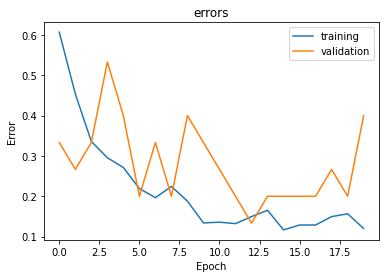

In [68]:
efnb0_training_acc = efnb0_history.history['accuracy']
efnb0_val_acc = efnb0_history.history['val_accuracy']

efnb0_training_err = []
efnb0_val_err = []
for i in range(len(efnb0_training_acc)):
    efnb0_training_err.append(1 - efnb0_training_acc[i])
    efnb0_val_err.append(1 - efnb0_val_acc[i])
plt.plot(efnb0_training_err, label = 'training')
plt.plot(efnb0_val_err, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc = 'upper right')
plt.title('errors')
plt.show()

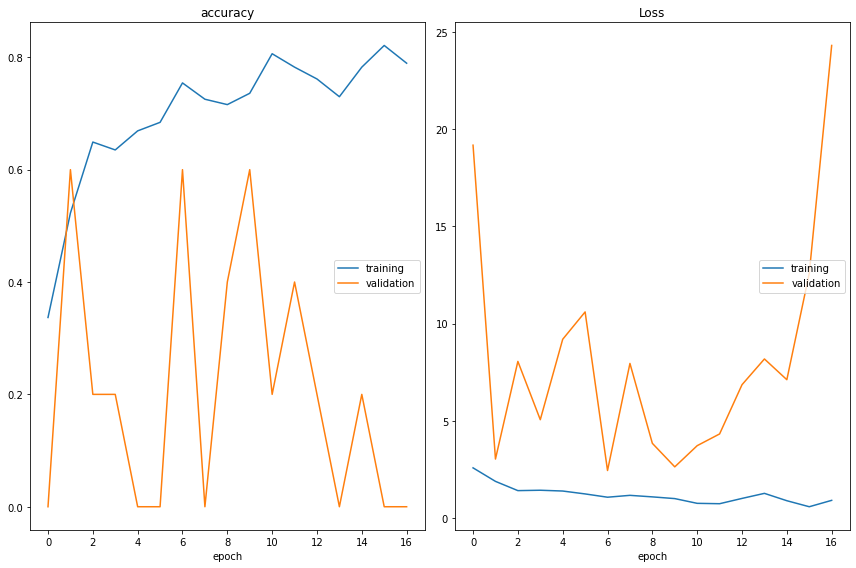

accuracy
	training         	 (min:    0.337, max:    0.821, cur:    0.789)
	validation       	 (min:    0.000, max:    0.600, cur:    0.000)
Loss
	training         	 (min:    0.580, max:    2.579, cur:    0.908)
	validation       	 (min:    2.442, max:   24.298, cur:   24.298)
57/57 [==============================] - 143s 3s/step - loss: 0.9082 - accuracy: 0.7895 - val_loss: 24.2979 - val_accuracy: 0.0000e+00


In [18]:
plot_loss_new = PlotLossesCallback()
checkpoint_vgg = ModelCheckpoint(filepath='vgg.weights.best.hdf5',
                                  save_best_only=True,verbose=1)

early_stop = EarlyStopping(monitor='val_loss',patience=10,
                           restore_best_weights=True,mode='min')
# fit vgg
n_steps = train_data_merge_vgg.samples // 100
n_val_steps = vali_data.samples // 100
vgg_history = model_vgg.fit(train_data_merge_vgg,
                            batch_size=100,
                            epochs=20,
                            validation_data=vali_data,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[checkpoint_vgg, early_stop, plot_loss_new],
                            verbose=1)

In [19]:
# refit with best weights
model_vgg.load_weights('vgg.weights.best.hdf5') # initialize the best trained weights

vgg_pred = model_vgg.predict(test_data)
vgg_pred_classes = np.argmax(vgg_pred, axis=1)

35/35 [==============================] - 79s 2s/step


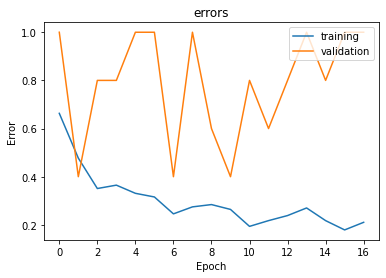

In [20]:
vgg_training_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']

vgg_training_err = []
vgg_val_err = []
for i in range(len(vgg_training_acc)):
    vgg_training_err.append(1 - vgg_training_acc[i])
    vgg_val_err.append(1 - vgg_val_acc[i])
plt.plot(vgg_training_err, label = 'training')
plt.plot(vgg_val_err, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc = 'upper right')
plt.title('errors')
plt.show()

### c.v. Report Precision, Recall, and F1 score for your model. Remember that this is a multi-class classification problem

In [21]:
true_classes = test_data.classes
# class_indices = train_data.class_indices
# class_indices = dict((v,k) for k,v in class_indices.items())

In [60]:
print(classification_report(true_classes,efnb0_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.89      0.89      0.89         9
           2       0.62      1.00      0.76         8
           3       0.75      0.75      0.75         8
           4       0.43      0.33      0.38         9
           5       0.62      0.56      0.59         9
           6       0.82      1.00      0.90         9
           7       0.86      0.67      0.75         9
           8       0.86      0.67      0.75         9
           9       1.00      0.89      0.94         9
          10       0.83      0.56      0.67         9
          11       0.80      0.89      0.84         9
          12       0.70      0.78      0.74         9
          13       0.75      0.33      0.46         9
          14       0.64      0.78      0.70         9
          15       0.55      0.75      0.63         8
          16       0.89      1.00      0.94         8
          17       0.86    

In [22]:
print(classification_report(true_classes,vgg_pred_classes))


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       1.00      0.11      0.20         9
           2       0.22      0.50      0.31         8
           3       1.00      0.38      0.55         8
           4       0.36      0.44      0.40         9
           5       0.50      0.78      0.61         9
           6       0.88      0.78      0.82         9
           7       0.71      0.56      0.63         9
           8       0.24      0.67      0.35         9
           9       1.00      0.78      0.88         9
          10       0.33      0.22      0.27         9
          11       0.73      0.89      0.80         9
          12       0.33      0.11      0.17         9
          13       0.24      0.56      0.33         9
          14       0.31      0.56      0.40         9
          15       0.00      0.00      0.00         8
          16       0.70      0.88      0.78         8
          17       0.50    